In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
!python --version
import sys
print('sys =',sys.version)
import tensorflow as tf
print('tf=',tf.__version__)
# !pip install tensorflow
# print(keras.__version__)
# !pip list | grep Keras
# import keras
# keras.__version__

Python 3.9.13
sys = 3.9.13 (tags/v3.9.13:6de2ca5, May 17 2022, 16:36:42) [MSC v.1929 64 bit (AMD64)]
tf= 2.13.1


In [4]:
from scipy.optimize import linear_sum_assignment
import tensorflow as tf
import tensorflow as T
from tensorflow import keras
from tensorflow.keras.models import model_from_json
# import tensorflow.keras.backend as k
from sklearn.manifold import TSNE
import copy
from multiprocessing import Pool

mse_func = tf.keras.losses.MeanSquaredError( reduction=tf.keras.losses.Reduction.SUM)
mae_func = tf.keras.losses.MeanAbsoluteError( reduction=tf.keras.losses.Reduction.SUM)
bc_func = tf.keras.losses.BinaryCrossentropy(  reduction=tf.keras.losses.Reduction.SUM) #from_logits=True,


In [5]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
import scipy.io as scio
import gzip
from six.moves import cPickle
import sys
# from collections.abc import MutableMapping
# import theano
# import theano.tensor as T
import math
# from keras.models import model_from_json

from PIL import Image

# import warnings
# warnings.filterwarnings("ignore")


In [6]:

def floatX(X):
    return np.asarray(X, dtype='float32')

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.)
    return z_mean + K.exp(z_log_var / 2) * epsilon
#=====================================
# def cluster_acc(Y_pred, Y):
#   from sklearn.utils.linear_assignment_ import linear_assignment
#   assert Y_pred.size == Y.size
#   D = max(Y_pred.max(), Y.max())+1
#   w = np.zeros((D,D), dtype=np.int64)
#   for i in range(Y_pred.size):
#     w[Y_pred[i], Y[i]] += 1
#   ind = linear_assignment(w.max() - w)
#   return sum([w[i,j] for i,j in ind])*1.0/Y_pred.size,ind

def cluster_acc(Y_pred, Y):
	assert Y_pred.size == Y.size
	D = max(Y_pred.max(), Y.max())+1
	w = np.zeros((D,D), dtype=np.int64)
	for i in range(Y_pred.size):
		w[Y_pred[i], Y[i]] += 1

	row_ind, col_ind = linear_sum_assignment(w.max() - w)
	return w[row_ind,col_ind].sum()/Y_pred.size, w

#==================================================
def load_data():
    # path = 'dataset/mnist/mnist.pkl.gz'
    # if path.endswith(".gz"):
    #     f = gzip.open(path, 'rb')
    # else:
    #     f = open(path, 'rb')

    # if sys.version_info < (3,):
    #     (x_train, y_train), (x_test, y_test) = cPickle.load(f)
    # else:
    #     (x_train, y_train), (x_test, y_test) = cPickle.load(f, encoding="bytes")

    # f.close()
    (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
    x_train = x_train.astype('float32') / 255.
    x_test = x_test.astype('float32') / 255.
    x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
    x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
    X = np.concatenate((x_train,x_test))
    Y = np.concatenate((y_train,y_test))
    return X,Y, x_train, y_train, x_test, y_test



In [7]:
def get_gamma(tempz):
    temp_Z = tf.expand_dims(tempz, -1)
    temp_Z = tf.tile(temp_Z, [1, 1, n_centroid])

    temp_u_tensor3 = tf.expand_dims(u_p, 0)
    temp_u_tensor3 = tf.tile(temp_u_tensor3, [batch_size, 1, 1])

    temp_lambda_tensor3 = tf.expand_dims(lambda_p, 0)
    temp_lambda_tensor3 = tf.tile(temp_lambda_tensor3, [batch_size, 1, 1])

    temp_theta_tensor3 = tf.expand_dims(theta_p, 0)
    temp_theta_tensor3 = tf.tile(temp_theta_tensor3, [latent_dim, 1])
    temp_theta_tensor3 = tf.expand_dims(temp_theta_tensor3, 0)
    temp_theta_tensor3 = tf.tile(temp_theta_tensor3, [batch_size, 1, 1])

    # temp_p_c_z = tf.exp(tf.reduce_sum((tf.log(temp_theta_tensor3) - 0.5 * tf.log(2 * math.pi * temp_lambda_tensor3)
    #                                    - tf.square(temp_Z - temp_u_tensor3) / (2 * temp_lambda_tensor3)),
    #                                   axis=1)) + 1e-10
    # return temp_p_c_z / tf.reduce_sum(temp_p_c_z, axis=-1, keepdims=True)

    temp_p_c_z = tf.reduce_sum((tf.math.log(temp_theta_tensor3) - 0.5 * tf.math.log(2 * math.pi * temp_lambda_tensor3)
                                       - tf.square(temp_Z - temp_u_tensor3) / (2 * temp_lambda_tensor3)),
                                      axis=1)
    temp_p_c_z_final = tf.nn.softmax(temp_p_c_z, axis=-1)
    # tf.print(temp_p_c_z_final)
    # for i in range(10):
    #     tf.print(temp_p_c_z_final[0,i])
    # tf.print(tf.shape(temp_p_c_z_final))
    # print('gamma_print =',    tf.print(temp_p_c_z_final) )
    return temp_p_c_z_final

# def get_gamma(tempz):
#     temp_Z=T.transpose(K.repeat(tempz,n_centroid),[0,2,1])
#     temp_u_tensor3=T.repeat(u_p.dimshuffle('x',0,1),batch_size,axis=0)
#     temp_lambda_tensor3=T.repeat(lambda_p.dimshuffle('x',0,1),batch_size,axis=0)
#     temp_theta_tensor3=theta_p.dimshuffle('x','x',0)*T.ones((batch_size,latent_dim,n_centroid))

#     temp_p_c_z=K.exp(K.sum((K.log(temp_theta_tensor3)-0.5*K.log(2*math.pi*temp_lambda_tensor3)-\
#                        K.square(temp_Z-temp_u_tensor3)/(2*temp_lambda_tensor3)),axis=1))
#     return temp_p_c_z/K.sum(temp_p_c_z,axis=-1,keepdims=True)

# def get_gamma(tempz):           #new
#     # temp_Z = tf.transpose(tf.repeat(tempz, n_centroid), [0, 2, 1])
#     # temp_Z = tf.transpose(tf.repeat(tf.reshape(tempz, [batch_size, -1, latent_dim]), n_centroid), [0, 2, 1])
#     print('tempz',np.shape( tempz))
#     print('tf.repeat(tempz, n_centroid)=',np.shape( tf.keras.backend.repeat(tempz, n_centroid)))
#
#     temp_Z = tf.transpose(tf.keras.backend.repeat(tempz, n_centroid), [0, 2, 1])
#     print('temp_Z',np.shape( temp_Z))
#
#     temp_u_tensor3 = tf.repeat(tf.expand_dims(u_p, 0), batch_size, axis=0)
#     temp_lambda_tensor3 = tf.repeat(tf.expand_dims(lambda_p, 0), batch_size, axis=0)
#     temp_theta_tensor3 = theta_p * tf.ones((batch_size, latent_dim, n_centroid))
#
#     temp_p_c_z = tf.exp(tf.reduce_sum((tf.math.log(temp_theta_tensor3) - 0.5 * tf.math.log(2 * np.pi * temp_lambda_tensor3) -
#                                         tf.math.square(temp_Z - temp_u_tensor3) / (2 * temp_lambda_tensor3)), axis=1))
#
#     print('temp_p_c_z =',np.shape( temp_p_c_z),temp_p_c_z)
#     print('tf.reduce_sum(temp_p_c_z, axis=-1, keepdims=True) =',np.shape( tf.reduce_sum(temp_p_c_z, axis=-1, keepdims=True)))
#     print('gamma =',temp_p_c_z / tf.reduce_sum(temp_p_c_z, axis=-1, keepdims=True))
#
#     return temp_p_c_z / tf.reduce_sum(temp_p_c_z, axis=-1, keepdims=True)
#=====================================================
# def gmm_para_init():

#     gmm_weights=scio.loadmat('trained_model_weights/mnist_weights_gmm.mat')
#     u_init=gmm_weights['u']
#     lambda_init=gmm_weights['lambda']
#     theta_init=np.squeeze(gmm_weights['theta'])

#     theta_p=theano.shared(np.asarray(theta_init,dtype='float32'),name="pi")
#     u_p=theano.shared(np.asarray(u_init,dtype='float32'),name="u")
#     lambda_p=theano.shared(np.asarray(lambda_init,dtype='float32'),name="lambda")
#     return theta_p,u_p,lambda_p

def gmm_para_init():          #new

    gmm_weights = scio.loadmat('trained_model_weights/mnist_weights_gmm.mat')
    u_init = gmm_weights['u']
    lambda_init = gmm_weights['lambda']
    theta_init = np.squeeze(gmm_weights['theta'])

    theta_p = np.asarray(theta_init, dtype='float32')
    u_p = np.asarray(u_init, dtype='float32')
    lambda_p = np.asarray(lambda_init, dtype='float32')

    return theta_p, u_p, lambda_p


In [8]:
ispretrain = True
batch_size = 1
latent_dim = 10
epochs =50
intermediate_dim = [500,500,2000]

X,Y, x_train, y_train, x_test, y_test = load_data()
# X = X[0:50]       #batch size should be less than end value
# Y = Y[0:50]

original_dim = 784
n_centroid = 10
theta_p, u_p, lambda_p = gmm_para_init()
#===================

x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim[0], activation='relu')(x)
h = Dense(intermediate_dim[1], activation='relu')(h)
h = Dense(intermediate_dim[2], activation='relu')(h)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
h_decoded = Dense(intermediate_dim[-1], activation='relu')(z)
h_decoded = Dense(intermediate_dim[-2], activation='relu')(h_decoded)
h_decoded = Dense(intermediate_dim[-3], activation='relu')(h_decoded)
x_decoded_mean = Dense(original_dim, activation='sigmoid')(h_decoded)

#========================
p_c_z = Lambda(get_gamma, output_shape=(n_centroid,))(z_mean)
sample_output = Model(x, z_mean)
p_c_z_output = Model(x, p_c_z)
#===========================================
vade = Model(x, x_decoded_mean)
vade.load_weights('trained_model_weights/mnist_weights_nn.h5')


In [9]:
# sample_output.set_weights(vade.weights[8])
print ('sample_output Model ',sample_output.weights[7])
print ('vade Model ', vade.weights[7])



sample_output Model  <tf.Variable 'dense_3/bias:0' shape=(10,) dtype=float32, numpy=
array([-0.2914416 ,  0.05799268, -0.86142206, -0.02681954,  0.35250485,
        0.38522655, -0.03433959, -0.00438974, -0.13656326,  0.19392991],
      dtype=float32)>
vade Model  <tf.Variable 'dense_3/bias:0' shape=(10,) dtype=float32, numpy=
array([-0.2914416 ,  0.05799268, -0.86142206, -0.02681954,  0.35250485,
        0.38522655, -0.03433959, -0.00438974, -0.13656326,  0.19392991],
      dtype=float32)>


In [10]:
# accuracy,ind = cluster_acc(np.argmax(p_c_z_output.predict(X,batch_size=batch_size),axis=1),Y)
accuracy,ind = cluster_acc(np.argmax(p_c_z_output.predict(x_test,batch_size=batch_size),axis=1),y_test)   #argmax, return max index which is cluster number
print ('MNIST dataset VaDE - clustering accuracy: %.2f%%'%(accuracy*100))


10000/10000 [==============================] - 5s 459us/step
MNIST dataset VaDE - clustering accuracy: 94.84%


In [11]:
# generating dataset
#==========================
def generation_init():
    gene_weights=scio.loadmat('trained_model_weights/mnist_gene.mat')
    u_gene=gene_weights['u']
    lambda_gene=gene_weights['lambda']
    theta_gene=np.squeeze(gene_weights['theta'])
    # print('4 lines fine')
    gene = model_from_json(open('trained_model_weights/mnist_gene.json').read())      #old, new both are same
    # Load the model architecture from JSON file
    # with open('trained_model_weights/mnist_gene.json') as f:            #new
    #     model_json = f.read()
    # gene = tf.keras.models.model_from_json(model_json)
    # print('model_json = ',gene)
    # print(gene.summary())
    # print('5 lines fine')
    # gene.load_weights('trained_model_weights/mnist_gene.mat')
    # gene.load_weights('trained_model_weights/mnist_weights_nn.h5')        #this is weights for encoder network
    gene.load_weights('trained_model_weights/mnist_gene_nn.h5')             #generator network
    # print('6 lines fine')
    return gene,theta_gene,u_gene,lambda_gene
#================================
#==================   digits generation
gene,g_theta,g_u,g_lambda = generation_init()
def mnist_gene():
    index=np.asarray(ind)[:,1]
    # print('index = ', index)
    # print('ind', ind)
    mnist_nice_png=np.zeros((280,280))
    for i in range(10):
        # print('np.where(index==i)', np.where(index==i)[0])
        # k=np.where(index==i)
        # k = np.asarray(k)
        # print('k=', np.shape(k), (k))
        # print('k=', int(k[0])    )
        k=i
        u=g_u[:,k]
        # u = np.reshape(u,[10,0])
        print('u=', np.shape(u))
        # print('g_u=', np.shape(g_u))
        l=g_lambda[:,k]
        # print('g_lambda=', np.shape(g_lambda), 'l=', l)  #l is vector of 10 values of all latent values
        # print('np.diag(l)=',np.shape(np.diag(l)),  np.diag(l))  #taken only diagonal values and other values are zero
        sample_n=10
        count=0
        while count<sample_n:
            z_sample=np.random.multivariate_normal(u,np.diag(l),(1,))  #for each latent space normal distribution is generated.
            # print('z_sample=', np.shape(z_sample))
            p=get_posterior(z_sample,g_u,g_lambda,g_theta)[k]
            # print('z_sample(cluster, latent_dim)=', np.shape(z_sample))
            if p>0.999:
                img=gene.predict(z_sample).reshape((28,28))*255.0
                mnist_nice_png[i*28:(i+1)*28,count*28:(count+1)*28]=img
                count+=1
        print('z_sample=', z_sample, 'uuuuu',  u)
    return np.asarray(mnist_nice_png,dtype=np.uint8)

def get_posterior(z,u,l,sita):
    z_m=np.repeat(np.transpose(z),n_centroid,1)
    posterior=np.exp(np.sum((np.log(sita)-0.5*np.log(2*math.pi*l)-\
                       np.square(z_m-u)/(2*l)),axis=0))
    # print('posterior info=','sita=',np.shape(sita),'l=',  np.shape(l),'z_m=', np.shape(z_m), 'u=',np.shape(u)   )
    return posterior/np.sum(posterior,axis=-1,keepdims=True)

# digit_image = mnist_gene()
# plt.imshow(digit_image,cmap=cm.gray)
# plt.show()
#Image.fromarray(digit_image).save('digits.jpg')

In [12]:
print ('phi_c = ',np.shape(theta_p))   # probability of each cluster
# print ('phi_c = ',theta_p)
# print ('phi_c = ',g_theta)
print ('mu_c = ',np.shape(u_p))         # axis 0 represent latents and axis 1 represent clusters.
# print ('mu_c = ', u_p)
print ('sigma_c = ',np.shape(g_lambda))
# print ('sigma_c = ', lambda_p)
# print ('sigma_c = ', g_lambda)
# g_theta,g_u,g_lambda
# theta_p, u_p, lambda_p

Zcenters = np.transpose(g_u)
# Zcenters = []
# for k in range(10):
#     u=g_u[:,k]
#     l=g_lambda[:,k]
#     Zcenters.append(np.random.multivariate_normal(u,np.diag(l)))  #for each latent space normal distribution is generated.
#     # Zcenters.append(np.random.multivariate_normal(u,np.diag(l),(1,)))  #for each latent space normal distribution is generated.
#     # Zcenters2=(np.random.multivariate_normal(g_u,g_lambda,(1,)))  #for each latent space normal distribution is generated.
#
#
# print ('Zcenters = ',np.shape(Zcenters))
# Zcenters = np.array(Zcenters)
# Zcenters = np.transpose(Zcenters)
# print ('Zcenters = ',np.shape(Zcenters))

# print ('np.mean(g_u,axis=0) = ',g_u)
# print ('np.mean(g_u,axis=0) = ',kmean_centers)



phi_c =  (10,)
mu_c =  (10, 10)
sigma_c =  (10, 10)


In [13]:
#todo: note these networks
#gene -> generator network
            # img=gene.predict(z_sample).reshape((28,28))     #from one sample
# sample_output = Model(x, z_mean)
# p_c_z_output = Model(x, p_c_z)
# vade = Model(x, x_decoded_mean)
# np.argmax(p_c_z_output.predict(x_test,batch_size=batch_size),axis=1)
# p_c_z_output.predict(x_test,batch_size=1)
# sample_output.predict(x_test)

###################################################################
reconst_img_Zcenters=gene.predict(Zcenters)     #from one sample
Mean_reconst_img_Zcenters = np.mean(reconst_img_Zcenters,axis=0)

print('reconst_img_Zcenters=',np.shape(reconst_img_Zcenters))
reconst_imgs = vade.predict(x_test)
print('reconst_imgs=',np.shape(reconst_imgs))

z_meanT_output = sample_output.predict(x_test[0:10000])
p_c_zT_output = p_c_z_output.predict(x_test[0:10000])    # = gamma_c
reconst_imgs_fromGenerator=gene.predict(z_meanT_output)     #from one sample

print('reconst_imgs_fromGenerator=', np.shape(reconst_imgs_fromGenerator))
print('z_meanT_output=', np.shape(z_meanT_output))
# print(z_meanT_output[0])
print('p_c_zT_output=', np.shape(p_c_zT_output))
# print( p_c_zT_output[0])
print('p_c_zT_output=', np.shape(np.argmax(p_c_zT_output,axis=1)))
# print(np.argmax(p_c_zT_output,axis=1)[0])



1/1 [==============================] - 0s 47ms/step
reconst_img_Zcenters= (10, 784)
313/313 [==============================] - 2s 5ms/step
reconst_imgs= (10000, 784)
313/313 [==============================] - 1s 2ms/step
reconst_imgs_fromGenerator= (10000, 784)
z_meanT_output= (10000, 10)
p_c_zT_output= (10000, 10)
p_c_zT_output= (10000,)


In [14]:
temppcz = p_c_z_output.predict(x_test[0:1])
print(x_test[0:1].shape)
print(temppcz.shape)



1/1 [==============================] - 0s 9ms/step
(1, 784)
(1, 10)


In [15]:
Nclusters =10
XSize =28
YSize = XSize
img_show=1
Ncolor =1

reconst_Kmean_test = copy.deepcopy(reconst_img_Zcenters)
true_mnist_digits = copy.deepcopy(x_test)

ytrain = y_test
xtrain_1D = x_test
Zn_estimations = reconst_img_Zcenters

In [16]:
# plt.imshow(np.reshape(Z_DAS,[XSize,XSize]),cmap=cm.gray)
# plt.imshow(np.reshape(Mean_reconst_img_Zcenters,[XSize,XSize]),cmap=cm.gray)
# plt.imshow(np.reshape(reconst_img_Zcenters[0],[XSize,XSize]),cmap=cm.gray)
# plt.imshow(np.reshape(np.mean(reconst_imgs,axis=0),[XSize,XSize]),cmap=cm.gray)
# plt.imshow(np.reshape(reconst_imgs[0],[XSize,XSize]),cmap=cm.gray)
# plt.imshow(np.reshape(reconst_imgs_fromGenerator[0],[XSize,XSize]),cmap=cm.gray)
# print(y_test[0])

z_latent= (10000, 10)


E:\Dropbox\Shared_Folders\PhD DCLAB Programming\Pycharm_interpretators\VaDE\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
E:\Dropbox\Shared_Folders\PhD DCLAB Programming\Pycharm_interpretators\VaDE\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
E:\Dropbox\Shared_Folders\PhD DCLAB Programming\Pycharm_interpretators\VaDE\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

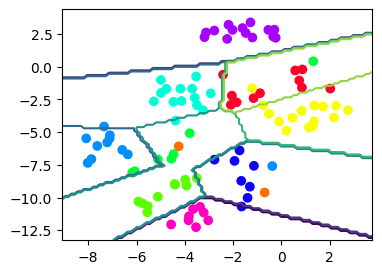

In [17]:
def plot_label_clustersT(data,labels):
    # display a 2D plot of the digit classes in the latent space
    # tsne = TSNE(n_components=2, verbose=0, perplexity=30.0, early_exaggeration=4.0, learning_rate='auto', n_iter=1000).fit_transform(z2)
    tsne = TSNE(n_components=2).fit_transform(data)
    # print('size of tsne space ', tf.shape(tsne))
    plt.figure(figsize=(6, 4))
    plt.scatter(tsne[:, 0], tsne[:, 1],c=labels, cmap=plt.cm.get_cmap('gist_rainbow_r',Nclusters))
    # plt.colorbar()
    plt.axis('off')
    #tosavefile
    # plt.title("t-SNE representation of z")
    # plt.xlabel("$\hat{z}$ [0]")
    # plt.ylabel("$\hat{z}$ [1]")

    # plt.title("Mean based custom t-SNE")
    # plt.xlabel("$\hat{\mu}$ [0]")
    # plt.ylabel("$\hat{\mu}$ [1]")
    # plt.savefig('Results/'+'Nclusters'+str(Nclusters)+'LatentS'+str(latent_dim)+'_TSNE_VaDE500_'+'.eps',bbox_inches = 'tight')
    # plt.savefig('Results/'+'Nclusters'+str(Nclusters)+'LatentS'+str(latent_dim)+'_TSNE_VaDE500_'+'.svg',bbox_inches = 'tight')
    # plt.show()
def plot_clustersT_boundry(data,labels):
    # tsne = TSNE(n_components=2, verbose=0, perplexity=30.0, early_exaggeration=4.0, learning_rate='auto', n_iter=1000).fit_transform(z2)
    tsne = TSNE(n_components=2).fit_transform(data)
    # plt.figure(figsize=(6, 4))
    # plt.scatter(tsne[:, 0], tsne[:, 1],c=labels, cmap=plt.cm.get_cmap('gist_rainbow_r',Nclusters))
    # plt.colorbar()
    from sklearn.cluster import KMeans
    from sklearn.inspection import DecisionBoundaryDisplay
    from sklearn.linear_model import LogisticRegression
    from sklearn import svm
    # import some data to play with
    # Create an instance of Logistic Regression Classifier and fit the data.

    logreg = LogisticRegression(C=1e5)
    # logreg = svm.SVC(kernel="linear", C=1000)
    logreg.fit(tsne, labels)
    _, ax = plt.subplots(figsize=(4, 3))
    # DecisionBoundaryDisplay.from_estimator(
    #     logreg,
    #     tsne,
    #     ax=ax,
    #     response_method="predict",
    #     plot_method="contour",           #contour pcolormesh
    #     eps=0.5,
    #     colors="k",
    #     levels=[-1, 0, 1],
    #     alpha=0.5,
    #     linestyles=["-"],
    # )
    # plot the decision function
    # ax = plt.gca()
    # DecisionBoundaryDisplay.from_estimator(
    #     logreg,
    #     tsne,
    #     plot_method="contour",
    #     colors="k",
    #     ax=ax,
    # )
    disp =DecisionBoundaryDisplay.from_estimator(logreg, tsne, response_method="auto", plot_method="contour",ax=ax)

    disp.ax_.scatter(tsne[:, 0], tsne[:, 1],c=labels,cmap='gist_rainbow_r')
    # plt.scatter(tsne[:, 0], tsne[:, 1],c=labels,cmap='gist_rainbow_r')
    # plt.xlabel("$\hat{\mu}$ [0]")
    # plt.ylabel("$\hat{\mu}$ [1]")
    plt.savefig('Results/'+'Nclusters'+str(Nclusters)+'LatentS'+str(latent_dim)+'_TSNE_VaDEBoundry_'+'.svg',bbox_inches = 'tight')
    # plt.show()
def get_sameCdataIndexes(testV,ytrain):
    y = []
    y = np.array(y,dtype=int)
    for i in range(len(ytrain)):
        if ytrain[i] ==testV:
            y= np.append(y,[i])
    # print(y)
    return y
# z_latent = []
# for i in range(20):
#     z_latent.append(Lambda(sampling, output_shape=(latent_dim,))([z_meanT_output, g_lambda[:,0] ]))
z_latent=(Lambda(sampling, output_shape=(latent_dim,))([z_meanT_output, np.mean(g_lambda,axis=1) ]))
z_latent = np.squeeze(z_latent)
print('z_latent=', np.shape(z_latent))

if img_show==1:
    # plot_label_clustersT(z_meanT_output, y_test)  #custom t-SNE
    # plot_label_clustersT(z_latent, y_test)  #custom t-SNE
    # plot_label_clustersT(z_latent[:500], y_test[:500])  #custom t-SNE
    plot_clustersT_boundry(z_meanT_output[:100], y_test[:100])  #custom t-SNE


In [18]:
if img_show>1:				#show initial centroids
	_, axs = plt.subplots(2, int(Nclusters/2),figsize=(10, 5))
	reconst_kmean_centers2 = np.reshape(reconst_img_Zcenters,[10,XSize,XSize])
	# reconst_imgs_fromGenerator10 = np.reshape(reconst_imgs_fromGenerator[:10],[10,XSize,XSize])
	# reconst_imgs_fromGenerator10 = np.reshape(reconst_imgs[:10],[10,XSize,XSize])

	print(np.shape((reconst_kmean_centers2)))
	for ix in range(2):
		for iy in range(0,int(Nclusters/2),1):#start ,end, step
				axs[ix,iy].imshow(reconst_kmean_centers2[(ix*(int(Nclusters/2)))+iy],cmap='gray_r')
				# axs[ix,iy].imshow(reconst_imgs_fromGenerator10[(ix*(int(Nclusters/2)))+iy],cmap='gray_r')
				axs[ix,iy].grid(False)

In [19]:
# main random and high to low var based index selection
Full_random_listIndex = np.random.choice(YSize*XSize, int(YSize*XSize), replace=False)
percent = .05
Full_DAE_listIndex = Full_random_listIndex[:int(YSize*XSize*percent)]
#find entropy for each cluster
def entropy_hx_CDAS():                 #from samples of clusters C-DAS
    entropycdas = np.zeros([YSize*XSize,Nclusters])
    for k in range(Nclusters):
        temptest = get_sameCdataIndexes(k,y_test)   # put real values not index
        recons_Zn = reconst_imgs[temptest]
        MSE_DASv = np.zeros([YSize*XSize])
        for iz in range (len(recons_Zn[:,0])):
            recons_Zn_temp = np.reshape(recons_Zn[iz],[YSize*XSize])
            recons_Zn_temp = recons_Zn_temp + 0.000001
            MSE_DASv = MSE_DASv + (recons_Zn_temp*np.log2(recons_Zn_temp)+(1-recons_Zn_temp)*np.log2(1-recons_Zn_temp))
        MSE_DASv = (-1*MSE_DASv)/len(recons_Zn[:,0])
        entropycdas[:,k] =  MSE_DASv
    return entropycdas
AvgEntropy_hx_CDAS = entropy_hx_CDAS()
def find_maxPower_CDAS(n):         # use all cluster values
    Full_DAE_listIndex = np.array([],dtype=int)
    temptest = get_sameCdataIndexes(n,y_test)[:100]   # put real values not index
    # print('temptest = ' , np.shape(temptest))
    recons_Zn = reconst_imgs[temptest]
    # recons_Zn = reconst_imgs              #for avg of all
    recons_Zn = np.mean(recons_Zn,axis=0)
    # print('recons_Zn = ' , np.shape(recons_Zn))
    MSE_DASv = np.square(recons_Zn)
    # MSE_DASv = (xinput1DDAS_mean)

    mv_index = np.argsort(MSE_DASv)[::-1]       #argsort give from low to high so [::-1] reverse the order of sorting
    Full_DAE_listIndex = np.append(Full_DAE_listIndex,mv_index)

    testImg1 = np.zeros([YSize*XSize])
    testImg1[Full_DAE_listIndex] = (np.reshape(MSE_DASv,[XSize*YSize]))[Full_DAE_listIndex]
    plt.imshow(np.reshape(testImg1,[YSize,XSize]),cmap='gray_r')
    return Full_DAE_listIndex

def find_maxPowerNDAS():         # use all cluster values
    Full_DAE_listIndex = np.array([],dtype=int)
    recons_Zn = np.mean(reconst_imgs,axis=0)
    MSE_DASv = np.square(recons_Zn)
    # MSE_DASv = (xinput1DDAS_mean)

    mv_index = np.argsort(MSE_DASv)[::-1]       #argsort give from low to high so [::-1] reverse the order of sorting
    Full_DAE_listIndex = np.append(Full_DAE_listIndex,mv_index)

    # testImg1 = np.zeros([YSize*XSize])
    # testImg1[Full_DAE_listIndex] = (np.reshape(MSE_DASv,[XSize*YSize]))[Full_DAE_listIndex]
    # plt.imshow(np.reshape(testImg1,[YSize,XSize]),cmap='gray_r')
    return Full_DAE_listIndex
def find_maxPowerNDAS_Cz():         # use all cluster values
    Full_DAE_listIndex = np.array([],dtype=int)
    recons_Zn = np.mean(reconst_img_Zcenters,axis=0)
    MSE_DASv = np.square(recons_Zn)
    # MSE_DASv = (xinput1DDAS_mean)

    mv_index = np.argsort(MSE_DASv)[::-1]       #argsort give from low to high so [::-1] reverse the order of sorting
    Full_DAE_listIndex = np.append(Full_DAE_listIndex,mv_index)

    testImg1 = np.zeros([YSize*XSize])
    testImg1[Full_DAE_listIndex] = (np.reshape(MSE_DASv,[XSize*YSize]))[Full_DAE_listIndex]
    plt.imshow(np.reshape(testImg1,[YSize,XSize]),cmap='gray_r')
    return Full_DAE_listIndex
def find_maxPower_input(ninput):         # use all cluster values
    Full_DAE_listIndex = np.array([],dtype=int)
    MSE_DASv = np.mean(np.square(ninput),axis=0)
    # MSE_DASv = np.square(recons_Zn)
    # MSE_DASv = (xinput1DDAS_mean)

    mv_index = np.argsort(MSE_DASv)[::-1]       #argsort give from low to high so [::-1] reverse the order of sorting
    Full_DAE_listIndex = np.append(Full_DAE_listIndex,mv_index)

    # testImg1 = np.zeros([YSize*XSize])
    # testImg1[Full_DAE_listIndex] = (np.reshape(MSE_DASv,[XSize*YSize]))[Full_DAE_listIndex]
    # plt.imshow(np.reshape(testImg1,[YSize,XSize]),cmap='gray_r')
    return Full_DAE_listIndex
def find_indexes_BCE_input(ninput):                 #from samples of clusters C-DAS
    Full_DAE_listIndex = np.array([],dtype=int)
    recons_Zn = ninput
    MSE_DASv = np.zeros([YSize*XSize])
    for iz in range (len(recons_Zn[:,0])):
        recons_Zn_temp = np.reshape(recons_Zn[iz],[YSize*XSize])
        recons_Zn_temp = recons_Zn_temp + 0.000001
        MSE_DASv = MSE_DASv + (recons_Zn_temp*np.log2(recons_Zn_temp)+(1-recons_Zn_temp)*np.log2(1-recons_Zn_temp))
    MSE_DASv = (-1*MSE_DASv)/len(recons_Zn[:,0])

    mv_index = np.argsort(MSE_DASv)[::-1]      #argsort give from low to high so [::-1] reverse the order of sorting
    Full_DAE_listIndex = np.append(Full_DAE_listIndex,mv_index)

    # testImg1 = np.zeros([YSize*XSize])
    # testImg1[Full_DAE_listIndex] = (np.reshape(MSE_DASv,[XSize*YSize]))[Full_DAE_listIndex]
    # plt.imshow(np.reshape(testImg1,[YSize,XSize]),cmap='gray_r')
    return Full_DAE_listIndex
def find_indexes_BCE_input_isitcorrect(ninput):                 #from samples of clusters C-DAS
    Full_DAE_listIndex = np.array([],dtype=int)
    recons_Zn = ninput
    recons_Zn_temp = np.reshape(recons_Zn,[YSize*XSize])
    recons_Zn_temp = recons_Zn_temp + 0.000001
    MSE_DASv = (recons_Zn_temp*np.log2(recons_Zn_temp)+(1-recons_Zn_temp)*np.log2(1-recons_Zn_temp))
    MSE_DASv = (-1*MSE_DASv)

    mv_index = np.argsort(MSE_DASv)[::-1]      #argsort give from low to high so [::-1] reverse the order of sorting
    Full_DAE_listIndex = np.append(Full_DAE_listIndex,mv_index)

    # testImg1 = np.zeros([YSize*XSize])
    # testImg1[Full_DAE_listIndex] = (np.reshape(MSE_DASv,[XSize*YSize]))[Full_DAE_listIndex]
    # plt.imshow(np.reshape(testImg1,[YSize,XSize]),cmap='gray_r')
    return Full_DAE_listIndex
def find_indexes_BCE_hx_CDAS(n):                 #from samples of clusters C-DAS
    Full_DAE_listIndex = np.array([],dtype=int)
    # xinput1DDAS = copy.deepcopy(np.reshape(Zn_estimations[n],[XSize*YSize]))
    temptest = get_sameCdataIndexes(n,y_test)   # put real values not index
    recons_Zn = reconst_imgs[temptest]
    MSE_DASv = np.zeros([YSize*XSize])
    for iz in range (len(recons_Zn[:,0])):
        recons_Zn_temp = np.reshape(recons_Zn[iz],[YSize*XSize])
        recons_Zn_temp = recons_Zn_temp + 0.00001
        MSE_DASv = MSE_DASv + (recons_Zn_temp*np.log2(recons_Zn_temp)+(1-recons_Zn_temp)*np.log2(1-recons_Zn_temp))
    MSE_DASv = (-1*MSE_DASv)/len(recons_Zn[:,0])


    #manual BCE
    # MSE_DASv = -(xinput1DDAS_mean*np.log2(xinput1DDAS_mean)+(1-xinput1DDAS_mean)*np.log2(1-xinput1DDAS_mean))
    # MSE_DASv = -(xinput1DDAS*np.log2(xinput1DDAS)+(1-xinput1DDAS)*np.log2(1-xinput1DDAS))

    mv_index = np.argsort(MSE_DASv)[::-1]      #argsort give from low to high so [::-1] reverse the order of sorting
    Full_DAE_listIndex = np.append(Full_DAE_listIndex,mv_index)

    # testImg1 = np.zeros([YSize*XSize])
    # testImg1[Full_DAE_listIndex] = (np.reshape(MSE_DASv,[XSize*YSize]))[Full_DAE_listIndex]
    # plt.imshow(np.reshape(testImg1,[YSize,XSize]),cmap='gray_r')
    return Full_DAE_listIndex

def find_indexes_BCE_hx_DAS_wegt():                 #from samples of clusters C-DAS
    Full_DAE_listIndex = np.array([],dtype=int)
    # xinput1DDAS = copy.deepcopy(np.reshape(Zn_estimations[n],[XSize*YSize]))
    MSE_DASv2 = np.zeros([YSize*XSize])
    for k in range(Nclusters):
        temptest = get_sameCdataIndexes(k,y_test)   # put real values not index
        recons_Zn = reconst_imgs[temptest]
        MSE_DASv = np.zeros([YSize*XSize])
        for iz in range (len(recons_Zn[:,0])):
            recons_Zn_temp = np.reshape(recons_Zn[iz],[YSize*XSize])
            recons_Zn_temp = recons_Zn_temp + 0.00001
            MSE_DASv = MSE_DASv + (recons_Zn_temp*np.log2(recons_Zn_temp)+(1-recons_Zn_temp)*np.log2(1-recons_Zn_temp))
        MSE_DASv = (-1*MSE_DASv)/len(recons_Zn[:,0])

        # MSE_DASv2 =  MSE_DASv2+ MSE_DASv*np.mean(g_lambda[:,Zn_serial_numbers[k]])
        MSE_DASv2 =  MSE_DASv2+ MSE_DASv*np.mean(g_lambda[:,k])
        # MSE_DASv2 =  MSE_DASv2+ MSE_DASv

    mv_index = np.argsort(MSE_DASv2)[::-1]      #argsort give from low to high so [::-1] reverse the order of sorting
    Full_DAE_listIndex = np.append(Full_DAE_listIndex,mv_index)
    testImg1 = np.zeros([YSize*XSize])
    testImg1[Full_DAE_listIndex] = (np.reshape(MSE_DASv2,[XSize*YSize]))[Full_DAE_listIndex]
    plt.imshow(np.reshape(testImg1,[YSize,XSize]),cmap='gray_r')
    return Full_DAE_listIndex
def find_indexes_BCE_hx_DAS_wegt_mean():                 #from samples of clusters C-DAS
    Full_DAE_listIndex = np.array([],dtype=int)
    # xinput1DDAS = copy.deepcopy(np.reshape(Zn_estimations[n],[XSize*YSize]))
    MSE_DASv2 = np.zeros([YSize*XSize])
    for k in range(500):
        recons_Zn = reconst_imgs[k]
        MSE_DASv = np.zeros([YSize*XSize])
        recons_Zn_temp = np.reshape(recons_Zn,[YSize*XSize])
        recons_Zn_temp = recons_Zn_temp + 0.00001
        MSE_DASv = MSE_DASv + (recons_Zn_temp*np.log2(recons_Zn_temp)+(1-recons_Zn_temp)*np.log2(1-recons_Zn_temp))
        MSE_DASv = (-1*MSE_DASv)/len(recons_Zn)

        MSE_DASv2 =  MSE_DASv2+ MSE_DASv
    mv_index = np.argsort(MSE_DASv2)[::-1]      #argsort give from low to high so [::-1] reverse the order of sorting
    Full_DAE_listIndex = np.append(Full_DAE_listIndex,mv_index)

    # testImg1 = np.zeros([YSize*XSize])
    # testImg1[Full_DAE_listIndex] = (np.reshape(MSE_DASv2,[XSize*YSize]))[Full_DAE_listIndex]
    # plt.imshow(np.reshape(testImg1,[YSize,XSize]),cmap='gray_r')
    return Full_DAE_listIndex
def find_indexes_BCE_hx_DAS_wegt_meanImg():                 #from samples of clusters C-DAS
    Full_DAE_listIndex = np.array([],dtype=int)
    # xinput1DDAS = copy.deepcopy(np.reshape(Zn_estimations[n],[XSize*YSize]))
    MSE_DASv2 = np.zeros([YSize*XSize])

    recons_Zn = np.mean(reconst_imgs, axis =0)
    MSE_DASv = np.zeros([YSize*XSize])
    recons_Zn_temp = np.reshape(recons_Zn,[YSize*XSize])
    recons_Zn_temp = recons_Zn_temp + 0.00001
    MSE_DASv = MSE_DASv + (recons_Zn_temp*np.log2(recons_Zn_temp)+(1-recons_Zn_temp)*np.log2(1-recons_Zn_temp))
    MSE_DASv = (-1*MSE_DASv)

    MSE_DASv2 =  MSE_DASv2+ MSE_DASv
    mv_index = np.argsort(MSE_DASv2)[::-1]      #argsort give from low to high so [::-1] reverse the order of sorting
    Full_DAE_listIndex = np.append(Full_DAE_listIndex,mv_index)

    # testImg1 = np.zeros([YSize*XSize])
    # testImg1[Full_DAE_listIndex] = (np.reshape(MSE_DASv2,[XSize*YSize]))[Full_DAE_listIndex]
    # plt.imshow(np.reshape(testImg1,[YSize,XSize]),cmap='gray_r')
    return Full_DAE_listIndex
def find_indexes_entropy_hx_DAS_wgted(input_gammaC):                 #from samples of clusters C-DAS
    Full_DAE_listIndex = np.array([],dtype=int)
    MSE_DASv2 = np.zeros([YSize*XSize])
    for k in range(Nclusters):
        # print(k,'', np.shape(AvgEntropy_hx_CDAS[:,k]), np.shape(input_gammaC[k]) )
        MSE_DASv2 =  MSE_DASv2+ AvgEntropy_hx_CDAS[:,k]*input_gammaC[k]
        # MSE_DASv2 =  MSE_DASv2+ AvgEntropy_hx_CDAS[:,k]

    mv_index = np.argsort(MSE_DASv2)[::-1]      #argsort give from low to high so [::-1] reverse the order of sorting
    Full_DAE_listIndex = np.append(Full_DAE_listIndex,mv_index)

    # testImg1 = np.zeros([YSize*XSize])              #to plot pixels
    # testImg1[Full_DAE_listIndex] = (np.reshape(MSE_DASv2,[XSize*YSize]))[Full_DAE_listIndex]
    # plt.imshow(np.reshape(testImg1,[YSize,XSize]),cmap='gray_r')
    return Full_DAE_listIndex

def find_indexes_entropy_hx_DAS_wgted_catog(k):                 #from samples of clusters C-DAS
    Full_DAE_listIndex_func = np.array([],dtype=int)
    # MSE_DASv2 = np.zeros([YSize*XSize])
    # for k in range(Nclusters):
        # print(k,'', np.shape(AvgEntropy_hx_CDAS[:,k]), np.shape(input_gammaC[k]) )
        # MSE_DASv2 =  MSE_DASv2+ AvgEntropy_hx_CDAS[:,k]*input_gammaC[k]
    MSE_DASv2 =   AvgEntropy_hx_CDAS[:,k]
    mv_index = np.argsort(MSE_DASv2)[::-1]      #argsort give from low to high so [::-1] reverse the order of sorting
    Full_DAE_listIndex_func = np.append(Full_DAE_listIndex_func,mv_index)
    # print('size of Full_DAE_listIndex_func= ', np.shape(Full_DAE_listIndex_func))

    # testImg1 = np.zeros([YSize*XSize])              #to plot pixels
    # testImg1[Full_DAE_listIndex_func] = (np.reshape(MSE_DASv2,[XSize*YSize]))[Full_DAE_listIndex_func]
    # plt.imshow(np.reshape(testImg1,[YSize,XSize]),cmap='gray_r')
    return Full_DAE_listIndex_func

def find_indexes_BCE_hx_DAS_wegt_pi():                 #from samples of clusters C-DAS
    Full_DAE_listIndex = np.array([],dtype=int)
    # xinput1DDAS = copy.deepcopy(np.reshape(Zn_estimations[n],[XSize*YSize]))
    MSE_DASv2 = np.zeros([YSize*XSize])
    for k in range(Nclusters):
        temptest = get_sameCdataIndexes(k,y_test)   # put real values not index
        recons_Zn = reconst_imgs[temptest]
        MSE_DASv = np.zeros([YSize*XSize])
        for iz in range (len(recons_Zn[:,0])):
            recons_Zn_temp = np.reshape(recons_Zn[iz],[YSize*XSize])
            recons_Zn_temp = recons_Zn_temp + 0.00001
            MSE_DASv = MSE_DASv + (recons_Zn_temp*np.log2(recons_Zn_temp)+(1-recons_Zn_temp)*np.log2(1-recons_Zn_temp))
        MSE_DASv = (-1*MSE_DASv)/len(recons_Zn[:,0])

        # MSE_DASv2 =  MSE_DASv2+ MSE_DASv*np.mean(g_lambda[:,Zn_serial_numbers[k]])
        MSE_DASv2 =  MSE_DASv2+ MSE_DASv*g_theta[k]
        # MSE_DASv2 =  MSE_DASv2+ MSE_DASv

    mv_index = np.argsort(MSE_DASv2)[::-1]      #argsort give from low to high so [::-1] reverse the order of sorting
    Full_DAE_listIndex = np.append(Full_DAE_listIndex,mv_index)
    # testImg1 = np.zeros([YSize*XSize])
    # testImg1[Full_DAE_listIndex] = (np.reshape(MSE_DASv2,[XSize*YSize]))[Full_DAE_listIndex]
    # plt.imshow(np.reshape(testImg1,[YSize,XSize]),cmap='gray_r')
    return Full_DAE_listIndex
def find_indexes_MSE_probndas(n,pn):    #N-DAS   formula
    Full_DAE_listIndex = np.array([],dtype=int)
    # Full_DAE_listIndex = np.ndarray(Full_DAE_listIndex)
    # xinput1DDAS = copy.deepcopy(np.reshape(Zn_estimations[n],[XSize*YSize]))          #one cluster output
    MSE_DASv = np.zeros([YSize*XSize])
    MSE_DASv2 = np.zeros([YSize*XSize])
    for n1 in range(Nclusters):
        # xinput1DDAS_mean = copy.deepcopy(np.reshape(np.mean(reconst_Kmean_test[n1::Nclusters], axis=0),[XSize*YSize]))    #mean(xh)
        temptest = get_sameCdataIndexes(n,y_test)   # put real values not index
        recons_Zn = reconst_imgs[temptest]
        for iz in range (len(recons_Zn[:,0])):
            MSE_DASv = MSE_DASv + np.square(reconst_img_Zcenters-np.reshape(recons_Zn[iz],[YSize*XSize]))
        MSE_DASv = MSE_DASv/len(recons_Zn[:,0])
        MSE_DASv2 = MSE_DASv2 + MSE_DASv*pn[n1]

    mv_index = np.argsort(MSE_DASv2)[::-1]       #argsort give from low to high so [::-1] reverse the order of sorting
    Full_DAE_listIndex = np.append(Full_DAE_listIndex,mv_index)
    # testImg1 = np.zeros([YSize*XSize])
    # testImg1[Full_DAE_listIndex] = (np.reshape(MSE_DASv2,[XSize*YSize]))[Full_DAE_listIndex]
    # plt.imshow(np.reshape(testImg1,[YSize,XSize]),cmap='gray_r')
    return Full_DAE_listIndex


In [20]:
def find_indexes_entropy_hx_DAS_neg_wgtedDAS(input_gammaC):                 #from samples of clusters C-DAS
    Full_DAE_listIndex = np.array([],dtype=int)

    recons_Zn = np.mean(reconst_imgs, axis =0)
    recons_Zn_temp = np.reshape(recons_Zn,[YSize*XSize])
    recons_Zn_temp = recons_Zn_temp + 0.00001
    MSE_DASv = (recons_Zn_temp*np.log2(recons_Zn_temp)+(1-recons_Zn_temp)*np.log2(1-recons_Zn_temp))
    MSE_DASv = (-1*MSE_DASv)                #nDAS

    MSE_DASv2 = np.zeros([YSize*XSize])
    for k in range(Nclusters):
        # print(k,'', np.shape(AvgEntropy_hx_CDAS[:,k]), np.shape(input_gammaC[k]) )
        MSE_DASv2 =  MSE_DASv2+ AvgEntropy_hx_CDAS[:,k]*input_gammaC[k]
        # MSE_DASv2 =  MSE_DASv2+ AvgEntropy_hx_CDAS[:,k]

    MSE_DASv2 = MSE_DASv - MSE_DASv2
    # print('MSE_DASv', MSE_DASv[300:400])
    # print('MSE_DASv2', MSE_DASv2[300:400])
    mv_index = np.argsort(MSE_DASv2)[::-1]      #argsort give from low to high so [::-1] reverse the order of sorting
    Full_DAE_listIndex = np.append(Full_DAE_listIndex,mv_index)

    # testImg1 = np.zeros([YSize*XSize])              #to plot pixels
    # testImg1[Full_DAE_listIndex] = (np.reshape(MSE_DASv2,[XSize*YSize]))[Full_DAE_listIndex]
    # plt.imshow(np.reshape(testImg1,[YSize,XSize]),cmap='gray_r')

    return Full_DAE_listIndex
def find_indexes_entropy_hx_DAS_neg_GDAS(ninput):                 #from samples of clusters C-DAS
    Full_DAE_listIndex = np.array([],dtype=int)

    recons_Zn = np.mean(reconst_imgs, axis =0)
    recons_Zn_temp = np.reshape(recons_Zn,[YSize*XSize])
    recons_Zn_temp = recons_Zn_temp + 0.00001
    MSE_DASvDAS = (recons_Zn_temp*np.log2(recons_Zn_temp)+(1-recons_Zn_temp)*np.log2(1-recons_Zn_temp))
    MSE_DASvDAS = (-1*MSE_DASvDAS)                #nDAS

    recons_Zn = ninput
    MSE_DASv = np.zeros([YSize*XSize])
    for iz in range (len(recons_Zn[:,0])):
        recons_Zn_temp = np.reshape(recons_Zn[iz],[YSize*XSize])
        recons_Zn_temp = recons_Zn_temp + 0.000001
        MSE_DASv = MSE_DASv + (recons_Zn_temp*np.log2(recons_Zn_temp)+(1-recons_Zn_temp)*np.log2(1-recons_Zn_temp))
    MSE_DASv = (-1*MSE_DASv)/len(recons_Zn[:,0])

    MSE_DASv2 = MSE_DASvDAS - MSE_DASv
    # print('MSE_DASv', MSE_DASv[300:400])
    # print('MSE_DASv2', MSE_DASv2[300:400])
    mv_index = np.argsort(MSE_DASv2)[::-1]      #argsort give from low to high so [::-1] reverse the order of sorting
    Full_DAE_listIndex = np.append(Full_DAE_listIndex,mv_index)

    # testImg1 = np.zeros([YSize*XSize])              #to plot pixels
    # testImg1[Full_DAE_listIndex] = (np.reshape(MSE_DASv2,[XSize*YSize]))[Full_DAE_listIndex]
    # plt.imshow(np.reshape(testImg1,[YSize,XSize]),cmap='gray_r')

    return Full_DAE_listIndex
def find_indexes_entropy_hx_DAS_neg_PDAS(k):                 #from samples of clusters C-DAS
    Full_DAE_listIndex = np.array([],dtype=int)

    recons_Zn = np.mean(reconst_imgs, axis =0)
    recons_Zn_temp = np.reshape(recons_Zn,[YSize*XSize])
    recons_Zn_temp = recons_Zn_temp + 0.00001
    MSE_DASv = (recons_Zn_temp*np.log2(recons_Zn_temp)+(1-recons_Zn_temp)*np.log2(1-recons_Zn_temp))
    MSE_DASv = (-1*MSE_DASv)                #nDAS

    MSE_DASv2 =   AvgEntropy_hx_CDAS[:,k]

    MSE_DASv2 = MSE_DASv - MSE_DASv2
    # print('MSE_DASv', MSE_DASv[300:400])
    # print('MSE_DASv2', MSE_DASv2[300:400])
    mv_index = np.argsort(MSE_DASv2)[::-1]      #argsort give from low to high so [::-1] reverse the order of sorting
    Full_DAE_listIndex = np.append(Full_DAE_listIndex,mv_index)

    # testImg1 = np.zeros([YSize*XSize])              #to plot pixels
    # testImg1[Full_DAE_listIndex] = (np.reshape(MSE_DASv2,[XSize*YSize]))[Full_DAE_listIndex]
    # plt.imshow(np.reshape(testImg1,[YSize,XSize]),cmap='gray_r')

    return Full_DAE_listIndex

def find_indexes_entropy_nDAS_neg_wgtfixed():                 #from samples of clusters C-DAS
    Full_DAE_listIndex = np.array([],dtype=int)

    recons_Zn = np.mean(reconst_imgs, axis =0)
    recons_Zn_temp = np.reshape(recons_Zn,[YSize*XSize])
    recons_Zn_temp = recons_Zn_temp + 0.00001
    MSE_DASvDAS = (recons_Zn_temp*np.log2(recons_Zn_temp)+(1-recons_Zn_temp)*np.log2(1-recons_Zn_temp))
    MSE_DASvDAS = (-1*MSE_DASvDAS)                #nDAS

    MSE_DASv2 = np.zeros([YSize*XSize])
    for k in range(Nclusters):
        temptest = get_sameCdataIndexes(k,y_test)   # put real values not index
        recons_Zn = reconst_imgs[temptest]
        MSE_DASv = np.zeros([YSize*XSize])
        for iz in range (len(recons_Zn[:,0])):
            recons_Zn_temp = np.reshape(recons_Zn[iz],[YSize*XSize])
            recons_Zn_temp = recons_Zn_temp + 0.00001
            MSE_DASv = MSE_DASv + (recons_Zn_temp*np.log2(recons_Zn_temp)+(1-recons_Zn_temp)*np.log2(1-recons_Zn_temp))
        MSE_DASv = (-1*MSE_DASv)/len(recons_Zn[:,0])

        # MSE_DASv2 =  MSE_DASv2+ MSE_DASv*np.mean(g_lambda[:,Zn_serial_numbers[k]])
        MSE_DASv2 =  MSE_DASv2+ MSE_DASv*g_theta[k]
        # MSE_DASv2 =  MSE_DASv2+ MSE_DASv
    # print('MSE_DASvDAS', MSE_DASvDAS[300:400])
    # print('MSE_DASv2', MSE_DASv2[300:400])
    MSE_DASv2 = MSE_DASvDAS - MSE_DASv2


    mv_index = np.argsort(MSE_DASv2)[::-1]      #argsort give from low to high so [::-1] reverse the order of sorting
    Full_DAE_listIndex = np.append(Full_DAE_listIndex,mv_index)

    # testImg1 = np.zeros([YSize*XSize])              #to plot pixels
    # testImg1[Full_DAE_listIndex] = (np.reshape(MSE_DASv2,[XSize*YSize]))[Full_DAE_listIndex]
    # plt.imshow(np.reshape(testImg1,[YSize,XSize]),cmap='gray_r')

    return Full_DAE_listIndex


In [21]:
# a = find_maxPower_CDAS(7)
a = find_indexes_BCE_hx_DAS_wegt_pi()
# a = find_indexes_entropy_nDAS_neg_wgtfixed()
# a = find_indexes_BCE_hx_CDAS(7)
# a = find_indexes_BCE_hx_DAS_wegt()
# a = find_indexes_BCE_hx_DAS_wegt_mean()
# a = find_indexes_BCE_hx_DAS_wegt_meanImg()
# a = find_indexes_entropy_hx_DAS_wgted_catog(1)


In [22]:
# a = find_indexes_BCE_hx_DAS_wegt_meanImg()
a = find_indexes_entropy_nDAS_neg_wgtfixed()


In [23]:
# Zn_serial_numbers = [4,1,8,7,3,9,5,6,2,0]       #write digits from clustering shown in Zn estimations
Zn_serial_numbers = np.array([1,0,8,5,9,4,7,6,3,2])         #to remove np.where error
# Zn_serial_numbers = np.array([9,1,8,4,0,6,7,3,2,5])         #to remove np.where error
actionSenPern = [0.005, 0.01, 0.05, 0.1, 0.2, .3,0.4, .5,0.6,0.8, 0.99]  #9


In [24]:
## todo: VaDE-Paper needs TD, simple with effective sensors % increase
def LS_ED_TIA_Probability(kc_cluster, reconst_img_Zcenters,x_test,Full_random_listIndex,Full_DAE_listIndex,Zcenters,Zn_serial_numbers,prob):
    actionSenPern = [0.005, 0.01, 0.05, 0.1, 0.2, .3,0.4, .5,0.6,0.8, 0.99]  #9
    # actionSenPern = [0.9]  #9
    MLL_pdf_All_Random = np.zeros ([len(actionSenPern),Nclusters])
    MLL_pdf_All_DAS = np.zeros ([len(actionSenPern),Nclusters])

    # samVNum =200
    samVNum =100
    Qindex =1
    steps = 3
    RND_On = 0
    black =1
    Random_MSE = np.zeros ([len(actionSenPern),Nclusters,samVNum])
    DAS_MSE = np.zeros([(len(actionSenPern)),Nclusters,samVNum])
    gammplot2 = np.zeros([(len(actionSenPern)),Nclusters])
    # for kc in range(Nclusters):
    for kc in range(1):
        kc=kc_cluster
        # print('Full_DAE_listIndex = ',np.shape(Full_DAE_listIndex))
        # test = get_sameCdataIndexes(Zn_serial_numbers[kc],y_test)   # put real values not index  old simple np.where
        test = get_sameCdataIndexes(kc,y_test)   # put real values not index
        # print ('MNIST dataset test: %.f'%(kc))

        # countRAND = 0
        # countDAS = 0
        countRAND = np.zeros([samVNum, len(actionSenPern)])
        countDAS = np.zeros([samVNum, len(actionSenPern)])

        for j in range(samVNum):
            # print('sample j = ',j)
            Full_DAE_listIndex = Full_random_listIndex[:int(YSize*XSize*0.005)]
            # DAE_listIndex = copy.deepcopy(Full_DAE_listIndex)
            # ML_Random = np.zeros(Nclusters)
            # ML_DAS = np.zeros(Nclusters)
            cluster_pass = 0
            while cluster_pass <1:
                if prob!=3:
                    if Ncolor==1:
                        if black==1:
                            xinput1DDAS =   np.zeros(YSize*XSize)
                        else:
                            xinput1DDAS =   copy.deepcopy(Mean_reconst_img_Zcenters)
                        xinput1DDAS[Full_DAE_listIndex] = x_test[test[j],Full_DAE_listIndex]
                    Z_DAS = np.zeros(784)
                    for i2 in range(Qindex):
                        Z_DAS = Z_DAS +vade.predict(np.reshape(xinput1DDAS,[1,XSize*XSize]),verbose=0)/Qindex #augmented input

                    #aDAS is predicted cluster for test sample j
                    # aDAS = np.argmax(p_c_z_output.predict(np.reshape(xinput1DDAS,[1,XSize*XSize]),batch_size=batch_size,verbose=0),axis=1) #for CDAS calculations
                    input_gammaC = p_c_z_output.predict(np.reshape(xinput1DDAS,[1,XSize*XSize]),batch_size=batch_size,verbose=0)[0] #for CDAS gamma_C all clusters
                    # print('aDAS j = ',aDAS)
                    draw = np.random.choice(Zn_serial_numbers, 1, p=input_gammaC)   #categories =Zn_serial_numbers, n=1, p is probabilities
                    draw = Zn_serial_numbers[draw[0]]
                if prob==1:
                    # temp_DAE_listIndex = find_indexes_BCE_hx_DAS_wegt()            #todo: update
                    temp_DAE_listIndex = find_indexes_entropy_hx_DAS_wgted(input_gammaC)            #todo: update
                elif prob==12:
                    temp_DAE_listIndex = find_indexes_entropy_hx_DAS_neg_wgtedDAS(input_gammaC)
                elif prob==11:
                    temp_DAE_listIndex = find_indexes_entropy_hx_DAS_wgted_catog(draw)            #todo: update
                elif prob==112:
                    temp_DAE_listIndex = find_indexes_entropy_hx_DAS_neg_PDAS(draw)            #todo: update
                elif prob==2:
                    # temp_DAE_listIndex = find_maxPower_CDAS(Zn_serial_numbers[kc])
                    temp_DAE_listIndex = find_maxPower_input(Z_DAS)
                elif prob==3:
                    # temp_DAE_listIndex = find_DAS_indexes_MSE(Zn_serial_numbers[kc])            #latent space mean
                    # temp_DAE_listIndex = find_maxPowerNDAS_Cz()          #latent space mean
                    # temp_DAE_listIndex = find_maxPowerNDAS()            #latent space mean
                    temp_DAE_listIndex = find_indexes_BCE_hx_DAS_wegt_pi()            #fixed Wgted DAS
                    # temp_DAE_listIndex = find_indexes_BCE_hx_DAS_wegt_mean()            #latent space mean
                    # temp_DAE_listIndex = find_indexes_BCE_hx_DAS_wegt_meanImg()            #nDAS - mean_entropy of xh
                    # temp_DAE_listIndex = find_indexes_entropy_nDAS_neg_wgtfixed()            #nDAS - wgted*0.1
                    steps = 784
                elif prob==4:
                    # temp_DAE_listIndex = find_indexes_BCE_hx_CDAS(Zn_serial_numbers[kc])            #latent space mean
                    # temp_DAE_listIndex = find_indexes_BCE_hx_CDAS(aDAS)            #latent space mean
                    # temp_DAE_listIndex = find_indexes_BCE_input_isitcorrect(Z_DAS)            #latent space mean
                    temp_DAE_listIndex = find_indexes_BCE_input(Z_DAS)            #latent space mean
                elif prob==41:
                    temp_DAE_listIndex = find_indexes_entropy_hx_DAS_neg_GDAS(Z_DAS)
                mv_index2 = np.setdiff1d(temp_DAE_listIndex,Full_DAE_listIndex,assume_unique=True) #yields the elements in `temp_DAE_listIndex` that are NOT in `list_1`
                # print('mv_index2 = ', mv_index2[:20])
                # Full_DAE_listIndex = np.append(Full_DAE_listIndex,mv_index2)                          #new for cdas and ndas
                Full_DAE_listIndex = np.append(Full_DAE_listIndex,mv_index2[:steps])      #for one by one sensors,
                # Full_DAE_listIndex = np.append(Full_DAE_listIndex,mv_index2[:int(YSize*XSize*0.05)])      #for
                # print('Full_DAE_listIndex = ', Full_DAE_listIndex[:])
                # print('length of Full_DAE_listIndex = ', np.shape(Full_DAE_listIndex))
                # DAE_listIndex = Full_DAE_listIndex[:int(YSize*XSize*actionSenPern[ks])]             #takes all elements in full_DAS till %sensors
                # print('mv_index2=',np.shape(mv_index2))
                # print('Full_DAE_listIndex=',np.shape(Full_DAE_listIndex))
                if  len(Full_DAE_listIndex)>=len(Full_random_listIndex):
                    cluster_pass += 1
            for ks in range(len(actionSenPern)):
                DAE_listIndex = Full_DAE_listIndex[:int(YSize*XSize*actionSenPern[ks])]
                if black==1:
                    xinput1DDAS =   np.zeros(YSize*XSize)
                else:
                    xinput1DDAS =   copy.deepcopy(Mean_reconst_img_Zcenters)
                xinput1DDAS[DAE_listIndex] = x_test[test[j],DAE_listIndex]

                if RND_On ==1:
                    random_listIndex = Full_random_listIndex[:int(YSize*XSize*actionSenPern[ks])]
                    if black==1:
                        xinput1D =   np.zeros(YSize*XSize)
                    else:
                        xinput1D =   copy.deepcopy(Mean_reconst_img_Zcenters)
                    xinput1D[random_listIndex] = x_test[test[j],random_listIndex]
                    aRAND = np.argmax(p_c_z_output.predict(np.reshape(xinput1D,[1,XSize*XSize]),batch_size=batch_size,verbose=0),axis=1)
                else:
                    aRAND = 0
                aDAS =  np.argmax(p_c_z_output.predict(np.reshape(xinput1DDAS,[1,XSize*XSize]),batch_size=batch_size,verbose=0),axis=1)
                # gammplot = p_c_z_output.predict(np.reshape(xinput1DDAS,[1,XSize*XSize]),batch_size=batch_size,verbose=0)
                # b = np.repeat(Zn_serial_numbers[kc],samVNum)
                b = Zn_serial_numbers[kc]
                # print('np.repeat(kc,len(test)) = ',np.shape(b ))
                # print('np.repeat(kc = ',b )
                # print('p_c_z_output.predict(xinput1D_RND,batch_size=batch_size) = ',np.shape(p_c_z_output.predict(xinput1D_RND,batch_size=batch_size)))
                # print('p_c_z_output = ',aDAS)
                # accuracyRND,_ = cluster_acc(np.argmax(p_c_z_output.predict(xinput1D_RND,batch_size=batch_size),axis=1),np.repeat(kc,samVNum))
                # accuracyDAS,_ = cluster_acc(np.argmax(p_c_z_output.predict(xinput1D_RND,batch_size=batch_size),axis=1),np.repeat(kc,samVNum))
                # # accuracy,_ = cluster_acc(np.argmax(p_c_z_output.predict(x_test[test],batch_size=batch_size),axis=1),y_test[test])
                # print ('MNIST dataset VaDE - clustering accuracyDAS: %.2f%%'%(accuracyDAS*100))
                # print(np.dtype(np.repeat(kc,samVNum)))
                if aRAND == b:
                    countRAND[j,ks] = countRAND[j,ks] + 1
                if aDAS ==b:
                    countDAS[j,ks] = countDAS[j,ks] +  1
                # countDAS = countDAS +np.count_nonzero((aDAS-b))

                # print('accuracyDAS=',countDAS[j])
                # diff_MSE = mse_func(np.reshape(true_mnist_digits[test[j]],[XSize*YSize]), Z_random).numpy()    #MSE calculation no noise
                # diff_MSE_DAS = mse_func(np.reshape(true_mnist_digits[test[j]],[XSize*YSize]), Z_DAS).numpy()    #MSE calculation
                Z_DAS = vade.predict(np.reshape(xinput1DDAS,[1,XSize*XSize]),verbose=0)
                diff_MSE_DAS = mse_func(true_mnist_digits[test[j]], Z_DAS).numpy()    #MSE calculation
                DAS_MSE[ks,kc,j] = diff_MSE_DAS
                if RND_On ==1:
                    Z_random = vade.predict(np.reshape(xinput1D,[1,XSize*XSize]),verbose=0)
                    diff_MSE =     mse_func(true_mnist_digits[test[j]], Z_random).numpy()    #MSE calculation no noise
                    Random_MSE[ks,kc,j] = diff_MSE


                print('ks = ',  ks, ' kc=',kc, ' j=',j)

                # print('gammplot =',np.shape(gammplot))
                # gammplot2[ks,:] = gammplot[0,:]

        # MLL_pdf_All_Random[ks,kc] = (countRAND)/samVNum
        # MLL_pdf_All_DAS[:,kc] = (countDAS)/samVNum
        MLL_pdf_All_Random[:,kc] = np.mean(countRAND,axis=0)
        MLL_pdf_All_DAS[:,kc] =    np.mean(countDAS,axis=0)/1           #mean auto divides
        # print('MLL_pdf_All_DAS = ',MLL_pdf_All_DAS)
        # print('np.mean(countDAS,axis=0) = ',np.mean(countDAS,axis=0))
        # print('countDAS = ',countDAS)

    # plt.imshow(np.reshape(Z_DAS,[XSize,XSize]),cmap=cm.gray)
    # plt.imshow(np.reshape(Mean_reconst_img_Zcenters,[XSize,XSize]),cmap=cm.gray)
    # plt.imshow(np.reshape(reconst_img_Zcenters[0],[XSize,XSize]),cmap=cm.gray)
    # for ip in range(10):
    #     # plt.plot(gammplot2[:,ip])
    #     plt.plot(actionSenPern,gammplot2[:,ip])
    # plt.plot(np.sum(gammplot2,axis=1))
    # print('gammplot2 =',np.shape(gammplot2))
    # plt.savefig('Results/'+'temp1.png',bbox_inches = 'tight')

    if samVNum>2:
        file = open('Vade_resultsTD.txt', 'a')
        file.write('\n-------TD_'+str(steps)+'_steps_Q='+str(Qindex)+' _Prob= '+str(prob)   )
        file.write('  cluster Kc ='+ str(kc) + '_black='+str(black)   )
        file.write('  test samples ='+str(samVNum))

        file.write('\n ED_pdf_Random'+str(kc)+'= ')
        file.write(np.array2string(np.mean(MLL_pdf_All_Random,axis=1)))
        file.write('\n ED_pdf_DAS'+str(kc)+'= ')
        file.write(np.array2string(np.mean(MLL_pdf_All_DAS,axis=1)))
        file.write('\n ED_NMSE_Random'+str(kc)+'= ')
        file.write(np.array2string(np.mean(Random_MSE,axis=(1, 2))))
        file.write('\n ED_NMSE_DAS'+str(kc)+'= ')
        file.write( np.array2string(np.mean(DAS_MSE,axis=(1, 2))))
        file.close()

    print('Prob = ',  prob, 'kc=',kc)
    if prob==1:
        print('ED_pdf_Random_TIA_Prob = ',  np.mean(MLL_pdf_All_Random,axis=1))
        print('ED_pdf_DAS_TIA_Prob = ',     np.mean(MLL_pdf_All_DAS,axis=1))
        print('ED_NMSE_Random_TIA_Prob = ',  np.mean(Random_MSE,axis=(1, 2)))
        print('ED_NMSE_DAS_TIA_Prob = ',     np.mean(DAS_MSE,axis=(1, 2)))
    else:
        print('ED_pdf_Random_TIA = ',  np.mean(MLL_pdf_All_Random,axis=1))
        print('ED_pdf_DAS_TIA = ',     np.mean(MLL_pdf_All_DAS,axis=1))
        print('ED_NMSE_Random_TIA = ',  np.mean(Random_MSE,axis=(1, 2)))
        print('ED_NMSE_DAS_TIA = ',     np.mean(DAS_MSE,axis=(1, 2)))

# LS_ED_TIA_Probability(7,reconst_img_Zcenters,x_test,Full_random_listIndex,Full_DAE_listIndex,Zcenters,Zn_serial_numbers,12)
# LS_ED_TIA_Probability(1,reconst_img_Zcenters,x_test,Full_random_listIndex,Full_DAE_listIndex,Zcenters,Zn_serial_numbers,41)
# for kc_clusterO in range(0,10,1):
#     LS_ED_TIA_Probability(kc_clusterO,reconst_img_Zcenters,x_test,Full_random_listIndex,Full_DAE_listIndex,Zcenters,Zn_serial_numbers,4)
#main

In [25]:
## todo: plot
def LS_ED_TIA_Probability(kc_cluster, reconst_img_Zcenters,x_test,Full_random_listIndex,Full_DAE_listIndex,Zcenters,Zn_serial_numbers,prob):
    actionSenPern = [0.005, 0.01, 0.05, 0.1, 0.2, .3,0.4, .5,0.6,0.8, 0.99]  #9
    # actionSenPern = [0.9]  #9
    MLL_pdf_All_Random = np.zeros ([len(actionSenPern),Nclusters])
    MLL_pdf_All_DAS = np.zeros ([len(actionSenPern),Nclusters])

    # samVNum =200
    samVNum =1
    Qindex =1
    steps = 3
    RND_On = 0
    Random_MSE = np.zeros ([len(actionSenPern),Nclusters,samVNum])
    DAS_MSE = np.zeros([(len(actionSenPern)),Nclusters,samVNum])
    gammplot2 = np.zeros([(len(actionSenPern)),Nclusters])
    # for kc in range(Nclusters):
    for kc in range(1):
        kc=kc_cluster
        # print('Full_DAE_listIndex = ',np.shape(Full_DAE_listIndex))
        # test = get_sameCdataIndexes(Zn_serial_numbers[kc],y_test)   # put real values not index  old simple np.where
        test = get_sameCdataIndexes(kc,y_test)   # put real values not index
        # print ('MNIST dataset test: %.f'%(kc))

        # countRAND = 0
        # countDAS = 0
        countRAND = np.zeros([samVNum, len(actionSenPern)])
        countDAS = np.zeros([samVNum, len(actionSenPern)])

        for j in range(samVNum):
            # print('sample j = ',j)
            Full_DAE_listIndex = Full_random_listIndex[:int(YSize*XSize*0.005)]
            # DAE_listIndex = copy.deepcopy(Full_DAE_listIndex)
            # ML_Random = np.zeros(Nclusters)
            # ML_DAS = np.zeros(Nclusters)
            cluster_pass = 0
            while cluster_pass <1:
                if Ncolor==1:
                    # xinput1DDAS =   copy.deepcopy(Mean_reconst_img_Zcenters)
                    xinput1DDAS =   np.zeros(YSize*XSize)
                    xinput1DDAS[Full_DAE_listIndex] = x_test[test[j],Full_DAE_listIndex]
                Z_DAS = np.zeros(784)
                for i2 in range(Qindex):
                    Z_DAS = Z_DAS +vade.predict(np.reshape(xinput1DDAS,[1,XSize*XSize]),verbose=0)/Qindex #augmented input

                #aDAS is predicted cluster for test sample j
                # aDAS = np.argmax(p_c_z_output.predict(np.reshape(xinput1DDAS,[1,XSize*XSize]),batch_size=batch_size,verbose=0),axis=1) #for CDAS calculations
                if prob !=3:
                    input_gammaC = p_c_z_output.predict(np.reshape(xinput1DDAS,[1,XSize*XSize]),batch_size=batch_size,verbose=0)[0] #for CDAS gamma_C all clusters
                    # print('aDAS j = ',aDAS)
                    draw = np.random.choice(Zn_serial_numbers, 1, p=input_gammaC)   #categories =Zn_serial_numbers, n=1, p is probabilities
                    draw = Zn_serial_numbers[draw[0]]
                if prob==1:
                    # temp_DAE_listIndex = find_indexes_BCE_hx_DAS_wegt()            #todo: update
                    temp_DAE_listIndex = find_indexes_entropy_hx_DAS_wgted(input_gammaC)            #todo: update
                elif prob==11:
                    temp_DAE_listIndex = find_indexes_entropy_hx_DAS_wgted_catog(draw)            #todo: update
                elif prob==2:
                    # temp_DAE_listIndex = find_maxPower_CDAS(Zn_serial_numbers[kc])
                    temp_DAE_listIndex = find_maxPower_input(Z_DAS)
                elif prob==3:
                    # temp_DAE_listIndex = find_DAS_indexes_MSE(Zn_serial_numbers[kc])            #latent space mean
                    # temp_DAE_listIndex = find_maxPowerNDAS_Cz()          #latent space mean
                    # temp_DAE_listIndex = find_maxPowerNDAS()            #latent space mean
                    # temp_DAE_listIndex = find_indexes_BCE_hx_DAS_wegt_mean()            #latent space mean
                    temp_DAE_listIndex = find_indexes_BCE_hx_DAS_wegt_meanImg()            #latent space mean

                elif prob==4:
                    # temp_DAE_listIndex = find_indexes_BCE_hx_CDAS(Zn_serial_numbers[kc])            #latent space mean
                    # temp_DAE_listIndex = find_indexes_BCE_hx_CDAS(aDAS)            #latent space mean
                    temp_DAE_listIndex = find_indexes_BCE_input(Z_DAS)            #latent space mean

                mv_index2 = np.setdiff1d(temp_DAE_listIndex,Full_DAE_listIndex,assume_unique=True) #yields the elements in `temp_DAE_listIndex` that are NOT in `list_1`
                # print('mv_index2 = ', mv_index2[:20])
                # Full_DAE_listIndex = np.append(Full_DAE_listIndex,mv_index2)                          #new for cdas and ndas
                Full_DAE_listIndex = np.append(Full_DAE_listIndex,mv_index2[:steps])      #for one by one sensors,
                # Full_DAE_listIndex = np.append(Full_DAE_listIndex,mv_index2[:int(YSize*XSize*0.05)])      #for
                # print('Full_DAE_listIndex = ', Full_DAE_listIndex[:])
                # print('length of Full_DAE_listIndex = ', np.shape(Full_DAE_listIndex))
                # DAE_listIndex = Full_DAE_listIndex[:int(YSize*XSize*actionSenPern[ks])]             #takes all elements in full_DAS till %sensors
                # print('mv_index2=',np.shape(mv_index2))
                # print('Full_DAE_listIndex=',np.shape(Full_DAE_listIndex))
                if  len(Full_DAE_listIndex)>=len(Full_random_listIndex):
                    cluster_pass += 1
            for ks in range(len(actionSenPern)):
                DAE_listIndex = Full_DAE_listIndex[:int(YSize*XSize*actionSenPern[ks])]
                # xinput1DDAS =   copy.deepcopy(Mean_reconst_img_Zcenters)
                xinput1DDAS =   np.zeros(YSize*XSize)
                xinput1DDAS[DAE_listIndex] = x_test[test[j],DAE_listIndex]

                if RND_On ==1:
                    random_listIndex = Full_random_listIndex[:int(YSize*XSize*actionSenPern[ks])]
                    xinput1D =      copy.deepcopy(Mean_reconst_img_Zcenters)            #added from mean of cluster center-> mean Xzn
                    # xinput1D =   np.zeros(YSize*XSize)
                    xinput1D[random_listIndex] = x_test[test[j],random_listIndex]
                    aRAND = np.argmax(p_c_z_output.predict(np.reshape(xinput1D,[1,XSize*XSize]),batch_size=batch_size,verbose=0),axis=1)
                else:
                    aRAND = 0
                aDAS =  np.argmax(p_c_z_output.predict(np.reshape(xinput1DDAS,[1,XSize*XSize]),batch_size=batch_size,verbose=0),axis=1)
                gammplot = p_c_z_output.predict(np.reshape(xinput1DDAS,[1,XSize*XSize]),batch_size=batch_size,verbose=0)
                # b = np.repeat(Zn_serial_numbers[kc],samVNum)
                b = Zn_serial_numbers[kc]
                # print('np.repeat(kc,len(test)) = ',np.shape(b ))
                # print('np.repeat(kc = ',b )
                # print('p_c_z_output.predict(xinput1D_RND,batch_size=batch_size) = ',np.shape(p_c_z_output.predict(xinput1D_RND,batch_size=batch_size)))
                # print('p_c_z_output = ',aDAS)
                # accuracyRND,_ = cluster_acc(np.argmax(p_c_z_output.predict(xinput1D_RND,batch_size=batch_size),axis=1),np.repeat(kc,samVNum))
                # accuracyDAS,_ = cluster_acc(np.argmax(p_c_z_output.predict(xinput1D_RND,batch_size=batch_size),axis=1),np.repeat(kc,samVNum))
                # # accuracy,_ = cluster_acc(np.argmax(p_c_z_output.predict(x_test[test],batch_size=batch_size),axis=1),y_test[test])
                # print ('MNIST dataset VaDE - clustering accuracyDAS: %.2f%%'%(accuracyDAS*100))
                # print(np.dtype(np.repeat(kc,samVNum)))
                if aRAND == b:
                    countRAND[j,ks] = countRAND[j,ks] + 1
                if aDAS ==b:
                    countDAS[j,ks] = countDAS[j,ks] +  1
                # countDAS = countDAS +np.count_nonzero((aDAS-b))

                # print('accuracyDAS=',countDAS[j])
                # diff_MSE = mse_func(np.reshape(true_mnist_digits[test[j]],[XSize*YSize]), Z_random).numpy()    #MSE calculation no noise
                # diff_MSE_DAS = mse_func(np.reshape(true_mnist_digits[test[j]],[XSize*YSize]), Z_DAS).numpy()    #MSE calculation
                Z_DAS = vade.predict(np.reshape(xinput1DDAS,[1,XSize*XSize]),verbose=0)
                diff_MSE_DAS = mse_func(true_mnist_digits[test[j]], Z_DAS).numpy()    #MSE calculation
                DAS_MSE[ks,kc,j] = diff_MSE_DAS
                if RND_On ==1:
                    Z_random = vade.predict(np.reshape(xinput1D,[1,XSize*XSize]),verbose=0)
                    diff_MSE =     mse_func(true_mnist_digits[test[j]], Z_random).numpy()    #MSE calculation no noise
                    Random_MSE[ks,kc,j] = diff_MSE


                print('ks = ',  ks, ' kc=',kc, ' j=',j)

                # print('gammplot =',np.shape(gammplot))
                gammplot2[ks,:] = gammplot[0,:]

        # MLL_pdf_All_Random[ks,kc] = (countRAND)/samVNum
        # MLL_pdf_All_DAS[:,kc] = (countDAS)/samVNum
        MLL_pdf_All_Random[:,kc] = np.mean(countRAND,axis=0)
        MLL_pdf_All_DAS[:,kc] =    np.mean(countDAS,axis=0)/1           #mean auto divides
        # print('MLL_pdf_All_DAS = ',MLL_pdf_All_DAS)
        # print('np.mean(countDAS,axis=0) = ',np.mean(countDAS,axis=0))
        # print('countDAS = ',countDAS)

    # plt.imshow(np.reshape(Z_DAS,[XSize,XSize]),cmap=cm.gray)
    # plt.imshow(np.reshape(Mean_reconst_img_Zcenters,[XSize,XSize]),cmap=cm.gray)
    # plt.imshow(np.reshape(reconst_img_Zcenters[0],[XSize,XSize]),cmap=cm.gray)
    for ip in range(10):
    #     # plt.plot(gammplot2[:,ip])
        plt.plot(actionSenPern,gammplot2[:,ip])
    # plt.plot(np.sum(gammplot2,axis=1))
    # print('gammplot2 =',np.shape(gammplot2))
    plt.savefig('Results/'+'temp1.png',bbox_inches = 'tight')

    if samVNum>2:
        file = open('Vade_resultsTD.txt', 'a')
        file.write('\n-------TD_'+str(steps)+'_steps_Q='+str(Qindex)+' _Prob= '+str(prob))
        file.write('  cluster Kc ='+ str(kc))
        file.write('  test samples ='+str(samVNum))

        file.write('\n ED_pdf_Random'+str(kc)+'= ')
        file.write(np.array2string(np.mean(MLL_pdf_All_Random,axis=1)))
        file.write('\n ED_pdf_DAS'+str(kc)+'= ')
        file.write(np.array2string(np.mean(MLL_pdf_All_DAS,axis=1)))
        file.write('\n ED_NMSE_Random'+str(kc)+'= ')
        file.write(np.array2string(np.mean(Random_MSE,axis=(1, 2))))
        file.write('\n ED_NMSE_DAS'+str(kc)+'= ')
        file.write( np.array2string(np.mean(DAS_MSE,axis=(1, 2))))
        file.close()

    print('Prob = ',  prob, 'kc=',kc)
    if prob==1:
        print('ED_pdf_Random_TIA_Prob = ',  np.mean(MLL_pdf_All_Random,axis=1))
        print('ED_pdf_DAS_TIA_Prob = ',     np.mean(MLL_pdf_All_DAS,axis=1))
        print('ED_NMSE_Random_TIA_Prob = ',  np.mean(Random_MSE,axis=(1, 2)))
        print('ED_NMSE_DAS_TIA_Prob = ',     np.mean(DAS_MSE,axis=(1, 2)))
    else:
        print('ED_pdf_Random_TIA = ',  np.mean(MLL_pdf_All_Random,axis=1))
        print('ED_pdf_DAS_TIA = ',     np.mean(MLL_pdf_All_DAS,axis=1))
        print('ED_NMSE_Random_TIA = ',  np.mean(Random_MSE,axis=(1, 2)))
        print('ED_NMSE_DAS_TIA = ',     np.mean(DAS_MSE,axis=(1, 2)))

# LS_ED_TIA_Probability(9,reconst_img_Zcenters,x_test,Full_random_listIndex,Full_DAE_listIndex,Zcenters,Zn_serial_numbers,11)
# LS_ED_TIA_Probability(0,reconst_img_Zcenters,x_test,Full_random_listIndex,Full_DAE_listIndex,Zcenters,Zn_serial_numbers,3)
# for kc_clusterO in range(0,10,1):
#     LS_ED_TIA_Probability(kc_clusterO,reconst_img_Zcenters,x_test,Full_random_listIndex,Full_DAE_listIndex,Zcenters,Zn_serial_numbers,3)


In [26]:
#todo: VaDE-Paper needs CD, simple with effective sensors % increase, corrected CD
def LS_ED_CIA_Probability(kc_cluster, reconst_img_Zcenters,x_test,Full_random_listIndex,Full_DAE_listIndex,Zcenters,Zn_serial_numbers,prob):
    actionSenPern = [0.005, 0.01, 0.05, 0.1, 0.2, .3,0.4, .5,0.6,0.8, 0.99]  #9
    # actionSenPern = [0.3]  #9
    MLL_pdf_All_Random = np.zeros ([len(actionSenPern),Nclusters])
    MLL_pdf_All_DAS = np.zeros ([len(actionSenPern),Nclusters])
    samVNum =100
    Qindex =1
    steps = 3
    RND_On = 0
    # black =1    current not possible
    gammplot = np.zeros([(len(actionSenPern)),Nclusters])

    Random_MSE = np.zeros ([len(actionSenPern),Nclusters,samVNum])
    DAS_MSE = np.zeros([(len(actionSenPern)),Nclusters,samVNum])

    for kc in range(Nclusters):
    # for kc in range(1):
    #     kc =kc_cluster

        # DAE_listIndex = Full_DAE_listIndex[:int(YSize*XSize*actionSenPern[ks])]
        test = get_sameCdataIndexes(kc,ytrain)   # put real values not index

        countRAND = np.zeros([samVNum, len(actionSenPern)])
        countDAS = np.zeros([samVNum, len(actionSenPern)])

        for j in range(samVNum):
        # for j in range(1):
        #     j=3
            Full_DAE_listIndex = Full_random_listIndex[:int(YSize*XSize*0.005)]
            # DAE_listIndex = copy.deepcopy(Full_DAE_listIndex)
            ML_Random = np.zeros([Nclusters,Nclusters ])
            ML_DAS = np.zeros([Nclusters,Nclusters])
            cluster_pass = 0
            while cluster_pass <1:
                if prob!=3:
                    for i in range(Nclusters):
                        if Ncolor==1:
                            xinput1DDAS = copy.deepcopy(np.reshape(reconst_img_Zcenters[i],[XSize*YSize]))
                            xinput1DDAS[Full_DAE_listIndex] = x_test[test[j],Full_DAE_listIndex]

                        ML_DAS[i] = p_c_z_output.predict(np.reshape(xinput1DDAS,[1,XSize*XSize]),batch_size=batch_size, verbose=0) #for CDAS calculations
                    # aDAS = np.argmax(np.max(ML_DAS,axis=1))
                    aDAS = np.argmax(np.diag(ML_DAS))
                    # print('aDAS=',aDAS)
                    xinput1DDAS = copy.deepcopy(np.reshape(reconst_img_Zcenters[aDAS],[XSize*YSize]))
                    xinput1DDAS[Full_DAE_listIndex] = x_test[test[j],Full_DAE_listIndex]
                    Z_DAS = np.zeros(784)
                    for i2 in range(Qindex):
                        Z_DAS = Z_DAS +vade.predict(np.reshape(xinput1DDAS,[1,XSize*XSize]),verbose=0)/Qindex #augmented input

                    input_gammaC = p_c_z_output.predict(np.reshape(xinput1DDAS,[1,XSize*XSize]),batch_size=batch_size,verbose=0)[0] #for CDAS gamma_C all clusters
                    draw = np.random.choice(Zn_serial_numbers, 1, p=input_gammaC)   #categories =Zn_serial_numbers, n=1, p is probabilities
                    draw = Zn_serial_numbers[draw[0]]
                    # print('draw=',draw)
                    # print('aDAS=',aDAS)

                if cluster_pass <1:
                    if prob==1:
                        # temp_DAE_listIndex = find_indexes_BCE_hx_DAS_wegt()            #todo: update
                        temp_DAE_listIndex = find_indexes_entropy_hx_DAS_wgted(input_gammaC)            #todo: update
                    elif prob==12:
                        temp_DAE_listIndex = find_indexes_entropy_hx_DAS_neg_wgtedDAS(input_gammaC)
                    elif prob==11:
                        temp_DAE_listIndex = find_indexes_entropy_hx_DAS_wgted_catog(draw)            #todo: update
                    elif prob==112:
                        temp_DAE_listIndex = find_indexes_entropy_hx_DAS_neg_PDAS(draw)            #todo: update
                    elif prob==2:
                        # temp_DAE_listIndex = find_maxPower_CDAS(Zn_serial_numbers[kc])
                        temp_DAE_listIndex = find_maxPower_input(Z_DAS)
                    elif prob==3:
                        # temp_DAE_listIndex = find_DAS_indexes_MSE(Zn_serial_numbers[kc])            #latent space mean
                        # temp_DAE_listIndex = find_maxPowerNDAS_Cz()          #latent space mean
                        # temp_DAE_listIndex = find_maxPowerNDAS()            #latent space mean
                        # temp_DAE_listIndex = find_indexes_BCE_hx_DAS_wegt_pi()            #fixed Wgted DAS
                        # temp_DAE_listIndex = find_indexes_BCE_hx_DAS_wegt_mean()            #latent space mean
                        # temp_DAE_listIndex = find_indexes_BCE_hx_DAS_wegt_meanImg()            #nDAS - mean_entropy of xh
                        temp_DAE_listIndex = find_indexes_entropy_nDAS_neg_wgtfixed()            #nDAS - wgted*0.1
                        steps = 784
                    elif prob==4:
                        # temp_DAE_listIndex = find_indexes_BCE_hx_CDAS(Zn_serial_numbers[kc])            #latent space mean
                        # temp_DAE_listIndex = find_indexes_BCE_hx_CDAS(aDAS)            #latent space mean
                        # temp_DAE_listIndex = find_indexes_BCE_input_isitcorrect(Z_DAS)            #latent space mean
                        temp_DAE_listIndex = find_indexes_BCE_input(Z_DAS)            #latent space mean
                    elif prob==41:
                        temp_DAE_listIndex = find_indexes_entropy_hx_DAS_neg_GDAS(Z_DAS)

                    mv_index2 = np.setdiff1d(temp_DAE_listIndex,Full_DAE_listIndex,assume_unique=True) #yields the elements in `temp_DAE_listIndex` that are NOT in `list_1`
                    # mv_index2 = np.setxor1d(temp_DAE_listIndex,Full_DAE_listIndex) #yields the elements in `temp_DAE_listIndex` that are NOT in `list_1`
                    Full_DAE_listIndex = np.append(Full_DAE_listIndex,mv_index2[:steps])
                    # print('temp_DAE_listIndex=',np.shape(temp_DAE_listIndex))
                    # print('mv_index2=',np.shape(mv_index2))
                    # print('Full_DAE_listIndex=',np.shape(Full_DAE_listIndex))

                    # DAE_listIndex = Full_DAE_listIndex[:int(YSize*XSize*actionSenPern[ks])]
                    # print('length of len(random_listIndex) = ', np.shape(random_listIndex))
                if  len(Full_DAE_listIndex)>=len(Full_random_listIndex):
                    cluster_pass += 1

            for ks in range(len(actionSenPern)):
                random_listIndex = Full_random_listIndex[:int(YSize*XSize*actionSenPern[ks])]
                DAE_listIndex = Full_DAE_listIndex[:int(YSize*XSize*actionSenPern[ks])]

                for i in range(Nclusters):
                    if Ncolor==1:
                        xinput1DDAS = copy.deepcopy(np.reshape(reconst_img_Zcenters[i],[XSize*YSize]))
                        xinput1DDAS[DAE_listIndex] = x_test[test[j],DAE_listIndex]
                        ML_DAS[i] = p_c_z_output.predict(np.reshape(xinput1DDAS,[1,XSize*XSize]),batch_size=batch_size, verbose=0) #for CDAS calculations
                        if RND_On ==1:
                            xinput1D = copy.deepcopy(np.reshape(reconst_img_Zcenters[i],[XSize*YSize]))
                            xinput1D[random_listIndex] = x_test[test[j],random_listIndex]
                            ML_Random[i] = p_c_z_output.predict(np.reshape(xinput1D,[1,XSize*XSize]),batch_size=batch_size, verbose=0) #for CDAS calculations

                # nr = np.argmax(np.max(ML_Random,axis=1))
                nr = np.argmax(np.diag(ML_Random))
                aDAS = np.argmax(np.diag(ML_DAS))

                if nr == Zn_serial_numbers[kc]:
                    countRAND[j,ks] = countRAND[j,ks] + 1
                if aDAS ==Zn_serial_numbers[kc]:
                    countDAS[j,ks] = countDAS[j,ks] +  1
                # countDAS = countDAS +np.count_nonzero((aDAS-b))
                # print(j,'  Zn_serial_numbers[kc]  ',Zn_serial_numbers[kc])
                # print(j,'  ML_Random  ',ML_Random)
                # print(j,'  aDAS  ',aDAS , 'ML_DAS=',ML_DAS  )
                xinput1DDAS = copy.deepcopy(np.reshape(reconst_img_Zcenters[aDAS],[XSize*YSize]))
                # xinput1DDAS = np.zeros([XSize*YSize])
                xinput1DDAS[DAE_listIndex] = x_test[test[j],DAE_listIndex]

                Z_DAS = vade.predict(np.reshape(xinput1DDAS,[1,XSize*XSize]),verbose=0)
                diff_MSE_DAS = mse_func(true_mnist_digits[test[j]], Z_DAS).numpy()    #MSE calculation
                DAS_MSE[ks,kc,j] = diff_MSE_DAS
                if RND_On ==1:
                    xinput1D = copy.deepcopy(np.reshape(reconst_img_Zcenters[nr],[XSize*YSize]))
                    xinput1D[random_listIndex] = x_test[test[j],random_listIndex]
                    Z_random = vade.predict(np.reshape(xinput1D,[1,XSize*XSize]),verbose=0)
                    diff_MSE =     mse_func(true_mnist_digits[test[j]], Z_random).numpy()    #MSE calculation no noise
                    Random_MSE[ks,kc,j] = diff_MSE

                print('ks = ',  ks, ' kc=',kc, ' j=',j)

        MLL_pdf_All_Random[:,kc] = np.mean(countRAND,axis=0)
        MLL_pdf_All_DAS[:,kc] =    np.mean(countDAS,axis=0)/1           #mean auto divides
        # MLL_pdf_All_Random[ks,kc] = countt
        # MLL_pdf_All_DAS[ks,kc] = countDAS
        # print('MLL detection probability = ', countt/len(test))
    # print('MLL_pdf_All_DAS = ',  MLL_pdf_All_DAS[0])

    # for ip in range(10):
    #     # plt.plot(gammplot2[:,ip])
    #     plt.plot(actionSenPern,gammplot[:,ip])
    # plt.plot(np.sum(gammplot2,axis=1))
    # plt.axes().set_facecolor("white")

    if samVNum>2:
        file = open('Vade_resultsCD.txt', 'a')
        file.write('\n-------CD_ MIDAS'+str(steps)+'_steps_Q='+str(Qindex)+' _Prob= '+str(prob))
        file.write('  cluster Kc ='+ str(kc))
        file.write('  test samples ='+str(samVNum))

        file.write('\n ED_pdf_Random_CIA'+str(kc)+'= ')
        file.write(np.array2string(np.mean(MLL_pdf_All_Random,axis=1)))
        file.write('\n ED_pdf_DAS_CIA'+str(kc)+'= ')
        file.write(np.array2string(np.mean(MLL_pdf_All_DAS,axis=1)))
        file.write('\n ED_NMSE_Random_CIA'+str(kc)+'= ')
        file.write(np.array2string(np.mean(Random_MSE,axis=(1, 2))))
        file.write('\n ED_NMSE_DAS_CIA'+str(kc)+'= ')
        file.write( np.array2string(np.mean(DAS_MSE,axis=(1, 2))))
        file.close()
    print('Prob = ',  prob, 'kc=',kc)
    if prob==1:
        print('ED_pdf_Random_CIA_Prob = ',  np.mean(MLL_pdf_All_Random,axis=1))
        print('ED_pdf_DAS_CIA_Prob = ',     np.mean(MLL_pdf_All_DAS,axis=1))
        print('ED_NMSE_Random_CIA_Prob = ',  np.mean(Random_MSE,axis=(1, 2)))
        print('ED_NMSE_DAS_CIA_Prob = ',     np.mean(DAS_MSE,axis=(1, 2)))
    else:
        print('ED_pdf_Random_CIA = ',  np.mean(MLL_pdf_All_Random,axis=1))
        print('ED_pdf_DAS_CIA = ',     np.mean(MLL_pdf_All_DAS,axis=1))
        print('ED_NMSE_Random_CIA = ',  np.mean(Random_MSE,axis=(1, 2)))
        print('ED_NMSE_DAS_CIA = ',     np.mean(DAS_MSE,axis=(1, 2)))

# LS_ED_CIA_Probability(7,reconst_img_Zcenters,x_test,Full_random_listIndex,Full_DAE_listIndex,Zcenters,Zn_serial_numbers,4)
# LS_ED_CIA_Probability(7,reconst_img_Zcenters,x_test,Full_random_listIndex,Full_DAE_listIndex,Zcenters,Zn_serial_numbers,4)
LS_ED_CIA_Probability(2,reconst_img_Zcenters,x_test,Full_random_listIndex,Full_DAE_listIndex,Zcenters,Zn_serial_numbers,3)

# for kc_clusterO in range(0,10,1):
#     LS_ED_CIA_Probability(kc_clusterO,reconst_img_Zcenters,x_test,Full_random_listIndex,Full_DAE_listIndex,Zcenters,Zn_serial_numbers,1)
#main

ks =  0  kc= 0  j= 0
ks =  1  kc= 0  j= 0
ks =  2  kc= 0  j= 0
ks =  3  kc= 0  j= 0
ks =  4  kc= 0  j= 0
ks =  5  kc= 0  j= 0
ks =  6  kc= 0  j= 0
ks =  7  kc= 0  j= 0
ks =  8  kc= 0  j= 0
ks =  9  kc= 0  j= 0
ks =  10  kc= 0  j= 0
ks =  0  kc= 0  j= 1
ks =  1  kc= 0  j= 1
ks =  2  kc= 0  j= 1
ks =  3  kc= 0  j= 1
ks =  4  kc= 0  j= 1
ks =  5  kc= 0  j= 1
ks =  6  kc= 0  j= 1
ks =  7  kc= 0  j= 1
ks =  8  kc= 0  j= 1
ks =  9  kc= 0  j= 1
ks =  10  kc= 0  j= 1
ks =  0  kc= 0  j= 2
ks =  1  kc= 0  j= 2
ks =  2  kc= 0  j= 2
ks =  3  kc= 0  j= 2
ks =  4  kc= 0  j= 2
ks =  5  kc= 0  j= 2
ks =  6  kc= 0  j= 2
ks =  7  kc= 0  j= 2
ks =  8  kc= 0  j= 2
ks =  9  kc= 0  j= 2
ks =  10  kc= 0  j= 2
ks =  0  kc= 0  j= 3
ks =  1  kc= 0  j= 3
ks =  2  kc= 0  j= 3
ks =  3  kc= 0  j= 3
ks =  4  kc= 0  j= 3
ks =  5  kc= 0  j= 3
ks =  6  kc= 0  j= 3
ks =  7  kc= 0  j= 3
ks =  8  kc= 0  j= 3
ks =  9  kc= 0  j= 3
ks =  10  kc= 0  j= 3
ks =  0  kc= 0  j= 4
ks =  1  kc= 0  j= 4
ks =  2  kc= 0  j= 4
ks =  3  

In [27]:
test = get_sameCdataIndexes(0,y_test)   # put real values not index  old simple np.where
temp =x_test[0]
# temp = np.reshape(temp,[1,784])
# print(np.shape(temp))
# print(np.shape(np.repeat(temp, 3, axis=0)))
# print(np.shape(x_test[test[:10]]))
# for i in range(10):
#     print(np.shape((x_test[test[i]])[Full_random_listIndex]))
#


In [28]:
y=0
x = np.where(Zn_serial_numbers==y)[0][0]
print(x)

1


(1028,)


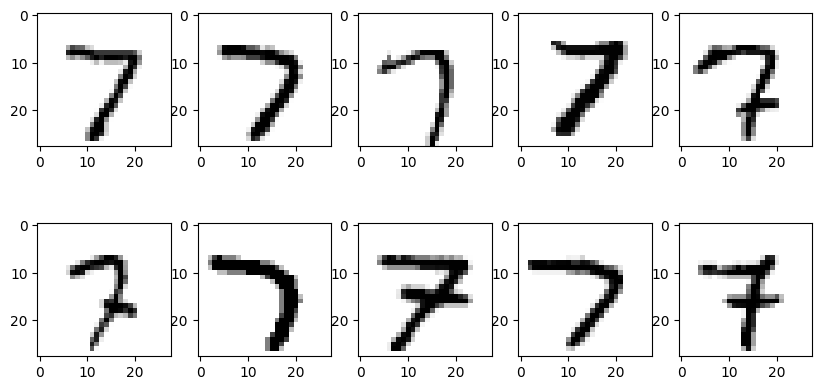

In [29]:
test = get_sameCdataIndexes(7,y_test)   # put real values not index
print(np.shape(test))
_, axs = plt.subplots(2, 5,figsize=(10, 5))
for ix in range(2):
    for iy in range(0,5,1):#start ,end, step
            axs[ix,iy].imshow(np.reshape(x_test[test[(ix*5)+iy]],[28,28]),cmap='gray_r')
            axs[ix,iy].grid(False)